In [1]:
%matplotlib inline
#Reference from https://pytorch.org/

In [2]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [3]:
# Data augmentation and normalization for training
# Just normalization for validation
'''
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
'''
data_transforms = {
    'train': transforms.Compose([
        #transforms.RandomResizedCrop(224),
        transforms.Resize([224, 224]),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(180),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize([224, 224]),
        #transforms.Resize(256),
        #transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


data_transforms = {
    'train': transforms.Compose([
        transforms.Resize([224, 224]),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(180),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize([224, 224]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


data_dir = '../AddMoreData061823/Class2/TTV'
l = []
l.append(datasets.ImageFolder(os.path.join(data_dir, 'train'), data_transforms['train']))
l.append(datasets.ImageFolder(os.path.join(data_dir, 'train'), data_transforms['train']))
l.append(datasets.ImageFolder(os.path.join(data_dir, 'train'), data_transforms['train']))
l.append(datasets.ImageFolder(os.path.join(data_dir, 'train'), data_transforms['train']))
#l.append(datasets.ImageFolder(os.path.join(data_dir, 'test'), data_transforms['test']))
image_datasetss = torch.utils.data.ConcatDataset(l)
image_datasets = {}
image_datasets['train'] = image_datasetss
image_datasets['test'] = datasets.ImageFolder(os.path.join(data_dir, 'test'), data_transforms['test'])
image_datasets['val'] = datasets.ImageFolder(os.path.join(data_dir, 'val'), data_transforms['test'])
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=5,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'test', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test', 'val']}
class_names = image_datasets['test'].classes
print(class_names)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(len( image_datasets['train']))
print(len( image_datasets['val']))
print(len( image_datasets['test']))

['0', '1', '2', '3', '4']
3020
92
98


Visualize a few images
^^^^^^^^^^^^^^^^^^^^^^
Let's visualize a few training images so as to understand the data
augmentations.



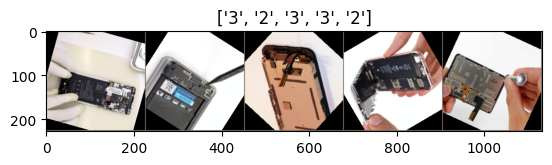

['0', '1', '2', '3', '4']


In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

print(class_names)

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs+1):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    #print(outputs)
                    #print(labels)
                    loss = criterion(outputs, labels)
    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Visualizing the model predictions
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Generic function to display predictions for a few images




In [6]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)

            m = nn.Softmax(dim=1)
            proOutput = m(outputs)
            pros = proOutput.detach().cpu().numpy()
            #print(pros)
            #_, preds = torch.max(outputs, 1)
            #pro = torch.max(proOutput, dim=1)[0]
            #_, predsmin = torch.min(outputs, 1)
            #promin = torch.min(proOutput, dim=1)[0]

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                #ax.set_title('predicted: %s with %s probabilities' %(class_names[preds[j]], round(pro[j].item(),4)))
                print('Actual label: %s' %(class_names[labels[j].item()]))
                for jj in range(5):
                    print('predicted: %s with %s probabilities' %(class_names[jj], round(pros[j][jj],4)))
                #print('predicted: %s with %s probabilities' %(class_names[1], round(pros[j][1],4)))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
                
        model.train(mode=was_training)

#visualize_model(model_ft)

In [8]:
model_ft = models.convnext_base(pretrained=True) #load googlenet.

model_ft.classifier[-1] = nn.Linear(1024, 5)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

C:\Users\haoyuliao\Anaconda3\envs\pytorch3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Base_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Base_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Train and evaluate
^^^^^^^^^^^^^^^^^^

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.




In [9]:
ep = 100
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=ep)

Epoch 1/100
----------
train Loss: 1.2801 Acc: 0.4417
val Loss: 1.2353 Acc: 0.5000

Epoch 2/100
----------
train Loss: 0.9965 Acc: 0.6026
val Loss: 1.1685 Acc: 0.5543

Epoch 3/100
----------
train Loss: 0.7131 Acc: 0.7169
val Loss: 0.9936 Acc: 0.6087

Epoch 4/100
----------
train Loss: 0.5001 Acc: 0.8149
val Loss: 0.9093 Acc: 0.7283

Epoch 5/100
----------
train Loss: 0.3266 Acc: 0.8854
val Loss: 1.0501 Acc: 0.6522

Epoch 6/100
----------
train Loss: 0.2507 Acc: 0.9076
val Loss: 0.9924 Acc: 0.6630

Epoch 7/100
----------
train Loss: 0.1192 Acc: 0.9609
val Loss: 1.0238 Acc: 0.6739

Epoch 8/100
----------
train Loss: 0.0421 Acc: 0.9904
val Loss: 0.8874 Acc: 0.7283

Epoch 9/100
----------
train Loss: 0.0292 Acc: 0.9947
val Loss: 0.9323 Acc: 0.7283

Epoch 10/100
----------
train Loss: 0.0239 Acc: 0.9954
val Loss: 0.9069 Acc: 0.7391

Epoch 11/100
----------
train Loss: 0.0201 Acc: 0.9987
val Loss: 0.8966 Acc: 0.7609

Epoch 12/100
----------
train Loss: 0.0178 Acc: 0.9983
val Loss: 0.9085 Ac

val Loss: 0.9026 Acc: 0.7717

Epoch 98/100
----------
train Loss: 0.0140 Acc: 0.9987
val Loss: 0.9026 Acc: 0.7717

Epoch 99/100
----------
train Loss: 0.0146 Acc: 0.9990
val Loss: 0.9026 Acc: 0.7717

Epoch 100/100
----------
train Loss: 0.0133 Acc: 0.9983
val Loss: 0.9026 Acc: 0.7717

Epoch 101/100
----------
train Loss: 0.0128 Acc: 0.9993
val Loss: 0.9026 Acc: 0.7717

Training complete in 207m 40s
Best val Acc: 0.782609


Actual label: 3
predicted: 0 with 0.005 probabilities
predicted: 1 with 0.0032 probabilities
predicted: 2 with 0.5779 probabilities
predicted: 3 with 0.4119 probabilities
predicted: 4 with 0.0019 probabilities


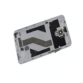

Actual label: 1
predicted: 0 with 1e-04 probabilities
predicted: 1 with 0.4329 probabilities
predicted: 2 with 0.5321 probabilities
predicted: 3 with 0.0311 probabilities
predicted: 4 with 0.0037 probabilities


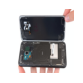

Actual label: 1
predicted: 0 with 0.0027 probabilities
predicted: 1 with 0.9424 probabilities
predicted: 2 with 0.0466 probabilities
predicted: 3 with 0.0083 probabilities
predicted: 4 with 0.0 probabilities


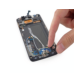

Actual label: 2
predicted: 0 with 0.0005 probabilities
predicted: 1 with 0.0 probabilities
predicted: 2 with 0.9888 probabilities
predicted: 3 with 0.0072 probabilities
predicted: 4 with 0.0035 probabilities


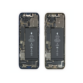

Actual label: 2
predicted: 0 with 0.0005 probabilities
predicted: 1 with 0.0003 probabilities
predicted: 2 with 0.998 probabilities
predicted: 3 with 0.001 probabilities
predicted: 4 with 0.0002 probabilities


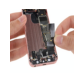

Actual label: 2
predicted: 0 with 1e-04 probabilities
predicted: 1 with 0.0005 probabilities
predicted: 2 with 0.9991 probabilities
predicted: 3 with 1e-04 probabilities
predicted: 4 with 0.0002 probabilities


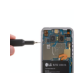

Actual label: 3
predicted: 0 with 0.0002 probabilities
predicted: 1 with 0.1059 probabilities
predicted: 2 with 0.0184 probabilities
predicted: 3 with 0.8754 probabilities
predicted: 4 with 1e-04 probabilities


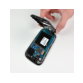

Actual label: 3
predicted: 0 with 0.0 probabilities
predicted: 1 with 0.0 probabilities
predicted: 2 with 0.0 probabilities
predicted: 3 with 1.0 probabilities
predicted: 4 with 0.0 probabilities


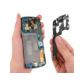

Actual label: 3
predicted: 0 with 0.0002 probabilities
predicted: 1 with 0.0118 probabilities
predicted: 2 with 0.0997 probabilities
predicted: 3 with 0.8883 probabilities
predicted: 4 with 0.0 probabilities


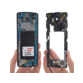

Actual label: 3
predicted: 0 with 1e-04 probabilities
predicted: 1 with 0.0 probabilities
predicted: 2 with 0.0021 probabilities
predicted: 3 with 0.9978 probabilities
predicted: 4 with 0.0 probabilities


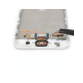

In [10]:
visualize_model(model_ft, 10)

In [11]:
correct = 0
total = 0
nb_classes = 5
confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for data in dataloaders['train']:
        images, labels = data[0].cuda(), data[1].cuda()
        outputs = model_ft(images)
        predicted = torch.round(outputs)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        for t, p in zip(labels.view(-1), predicted.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
        

print('Accuracy of the network on the %s train images: %d %%' % (total,
    100 * correct / total))

print(confusion_matrix)
b= torch.sum(confusion_matrix, dim=1)
print(confusion_matrix/torch.reshape(b, (-1, 1))) #Normalizing


Accuracy of the network on the 3020 train images: 100 %
tensor([[ 212.,    0.,    0.,    0.,    0.],
        [   0.,  544.,    0.,    0.,    0.],
        [   0.,    0., 1068.,    0.,    0.],
        [   0.,    0.,    0., 1052.,    0.],
        [   0.,    0.,    0.,    0.,  144.]])
tensor([[1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.]])


In [12]:
correct = 0
total = 0
nb_classes = 5
confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for data in dataloaders['val']:
        images, labels = data[0].cuda(), data[1].cuda()
        outputs = model_ft(images)
        predicted = torch.round(outputs)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        for t, p in zip(labels.view(-1), predicted.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
        

print('Accuracy of the network on the %s val images: %d %%' % (total,
    100 * correct / total))

print(confusion_matrix)
b= torch.sum(confusion_matrix, dim=1)
print(confusion_matrix/torch.reshape(b, (-1, 1))) #Normalizing


Accuracy of the network on the 92 val images: 78 %
tensor([[ 4.,  0.,  0.,  2.,  0.],
        [ 1., 12.,  2.,  2.,  0.],
        [ 0.,  1., 27.,  4.,  1.],
        [ 0.,  2.,  4., 26.,  0.],
        [ 0.,  0.,  1.,  0.,  3.]])
tensor([[0.6667, 0.0000, 0.0000, 0.3333, 0.0000],
        [0.0588, 0.7059, 0.1176, 0.1176, 0.0000],
        [0.0000, 0.0303, 0.8182, 0.1212, 0.0303],
        [0.0000, 0.0625, 0.1250, 0.8125, 0.0000],
        [0.0000, 0.0000, 0.2500, 0.0000, 0.7500]])


In [13]:
correct = 0
total = 0
nb_classes = 5
confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for data in dataloaders['test']:
        images, labels = data[0].cuda(), data[1].cuda()
        outputs = model_ft(images)
        predicted = torch.round(outputs)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        for t, p in zip(labels.view(-1), predicted.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
        

print('Accuracy of the network on the %s test images: %d %%' % (total,
    100 * correct / total))

print(confusion_matrix)
b= torch.sum(confusion_matrix, dim=1)
print(confusion_matrix/torch.reshape(b, (-1, 1))) #Normalizing


Accuracy of the network on the 98 test images: 77 %
tensor([[ 2.,  0.,  2.,  4.,  0.],
        [ 0., 14.,  2.,  1.,  0.],
        [ 0.,  0., 27.,  7.,  0.],
        [ 0.,  2.,  3., 29.,  0.],
        [ 0.,  0.,  0.,  1.,  4.]])
tensor([[0.2500, 0.0000, 0.2500, 0.5000, 0.0000],
        [0.0000, 0.8235, 0.1176, 0.0588, 0.0000],
        [0.0000, 0.0000, 0.7941, 0.2059, 0.0000],
        [0.0000, 0.0588, 0.0882, 0.8529, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.2000, 0.8000]])


In [14]:
if not os.path.exists('trained models'):
   os.makedirs('trained models')
PATH = './trained models/convnext_base-TTVClass2-BestEP%s.pth' %(ep)
torch.save(model_ft.state_dict(), PATH)